In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import math
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import clear_output
from typing import Union, Tuple, Dict

# 1.Model Building

### Model training

In [178]:
df = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
df_t = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [128]:
# Removing unnecessary columns
df = df.drop(columns=['Id'])

threshold = 0.5 
columns_to_drop = []

for col in df.columns:
    missing_percentage = df[col].isna().mean()
    if missing_percentage >= threshold:
        columns_to_drop.append(col)

threshold = 0.9 * len(df)

for column in df.columns:
    if df[column].value_counts().max() > threshold:
        columns_to_drop.append(column)

df = df.drop(columns=columns_to_drop)

In [129]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ordinal = OrdinalEncoder()

ordinal.fit(X_train.select_dtypes(include = ['object']))

X_train[X_train.select_dtypes(include=['object']).columns] = ordinal.transform(X_train.select_dtypes(include=['object']))

dump(ordinal, '../models/ordinal_encoder.pkl')
dump(X.columns, '../models/columns.pkl')

['../models/columns.pkl']

In [130]:
standard = StandardScaler()

standard.fit(X_train)
X_train = standard.transform(X_train)

dump(standard, '../models/standard_scaler.pkl')

['../models/standard_scaler.pkl']

In [131]:
xgb_reg = xgb.XGBRegressor(n_jobs=-1)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [132]:
type(xgb_reg)

xgboost.sklearn.XGBRegressor

In [133]:
dump(xgb_reg, '../models/model_before_tuning.pkl')

['../models/model_before_tuning.pkl']

### Model evaluation

In [134]:
X_test[X_test.select_dtypes(include=['object']).columns] = ordinal.transform(X_test.select_dtypes(include=['object']))

X_test = standard.transform(X_test)

In [135]:
y_pred_test = xgb_reg.predict(X_test)
r2score = round(r2_score(y_pred_test,y_test),2) #*100
print("R2 Score on Test Data is :", r2score)

R2 Score on Test Data is : 0.9


In [136]:
mse = mean_squared_error(y_test, y_pred_test)

rmse = round(math.sqrt(mse), 2)

print("rmse Score on Test Data is :", rmse)

rmse Score on Test Data is : 25792.78


In [137]:
def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return print("RMSLE Score on Test Data is :", round(rmsle, precision))

In [138]:
compute_rmsle(y_test, y_pred_test)

RMSLE Score on Test Data is : 0.15


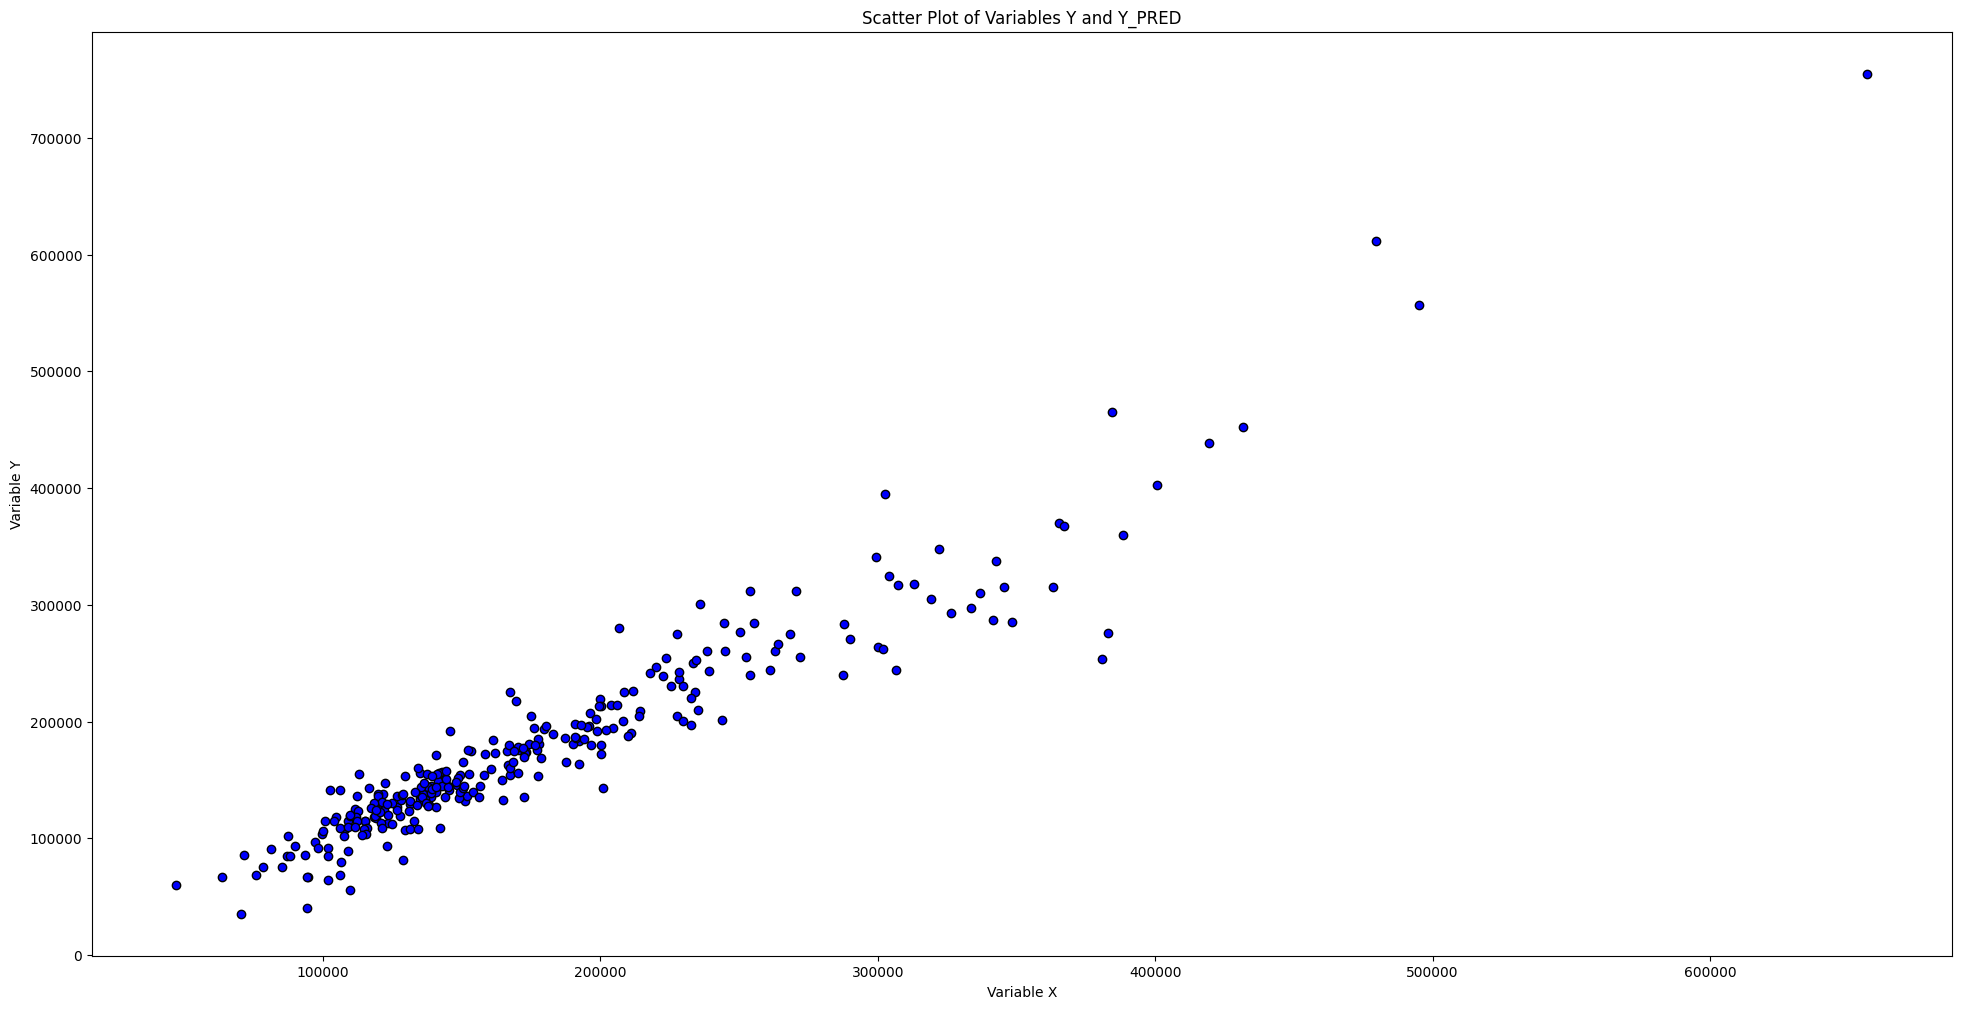

In [139]:
plt.figure(figsize=(24, 12))
plt.scatter(y_pred_test, list(y_test), color='blue', edgecolors='black') #, label=f"Correlation: {correlation:.2f}")
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.title('Scatter Plot of Variables Y and Y_PRED')
# plt.legend()
plt.grid(False)
plt.show()

### Model HyperParameter Tuning

In [140]:
model = load('../models/model_before_tuning.pkl')

In [141]:
params = {
'n_estimators' : [100, 150, 200, 250, 300, 350, 400, 500, 750, 800, 850], # no of trees
'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5], # eta
'min_child_weight': [1, 5, 7, 10],
'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
'max_depth': [3, 4, 5, 10, 12, 15, 20]
}
folds = 5
param_comb = 100

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=folds, verbose=3, random_state=42)

random_search.fit(X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.25, max_depth=20, min_child_weight=7, n_estimators=350, subsample=1.0;, score=0.781 total time=   0.8s
[CV 3/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.827 total time=   0.9s
[CV 2/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.803 total time=   0.9s
[CV 4/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.785 total time=   0.9s
[CV 1/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.04, max_depth=20, min_child_weight=10, n_estimators=500, subsample=1.0;, score=0.778 total time=   0.9s
[CV 2/5] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.25, max_depth=20, min_child_weight=7, n_estimators=350

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.1, 0.25,
                                                          0.5],
                                        'max_depth': [3, 4, 5, 10, 12, 15, 20],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 500,
                                                         750, 800, 850],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=3)

In [142]:
print ('We can get score of :', random_search.best_score_,' using', random_search.best_params_)

We can get score of : 0.8508294197866058  using {'subsample': 0.6, 'n_estimators': 350, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.6}


In [143]:
xgb_reg_hpt = xgb.XGBRegressor(subsample = random_search.best_params_['subsample'], n_estimators = random_search.best_params_['n_estimators'], min_child_weight = random_search.best_params_['min_child_weight'], max_depth = random_search.best_params_['max_depth'], learning_rate = random_search.best_params_['learning_rate'], gamma = random_search.best_params_['gamma'], colsample_bytree = random_search.best_params_['colsample_bytree'], n_jobs = -1)
xgb_reg_hpt.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=350, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [144]:
dump(xgb_reg_hpt, '../models/model.joblib')

['../models/model.joblib']

### Model evaluation after tuning

In [145]:
y_pred_test_hpt = xgb_reg_hpt.predict(X_test)
r2score = round(r2_score(y_pred_test_hpt, y_test),2) #*100
print("R2 Score on Test Data is :", r2score)

R2 Score on Test Data is : 0.89


In [146]:
compute_rmsle(y_test, y_pred_test_hpt)

RMSLE Score on Test Data is : 0.14


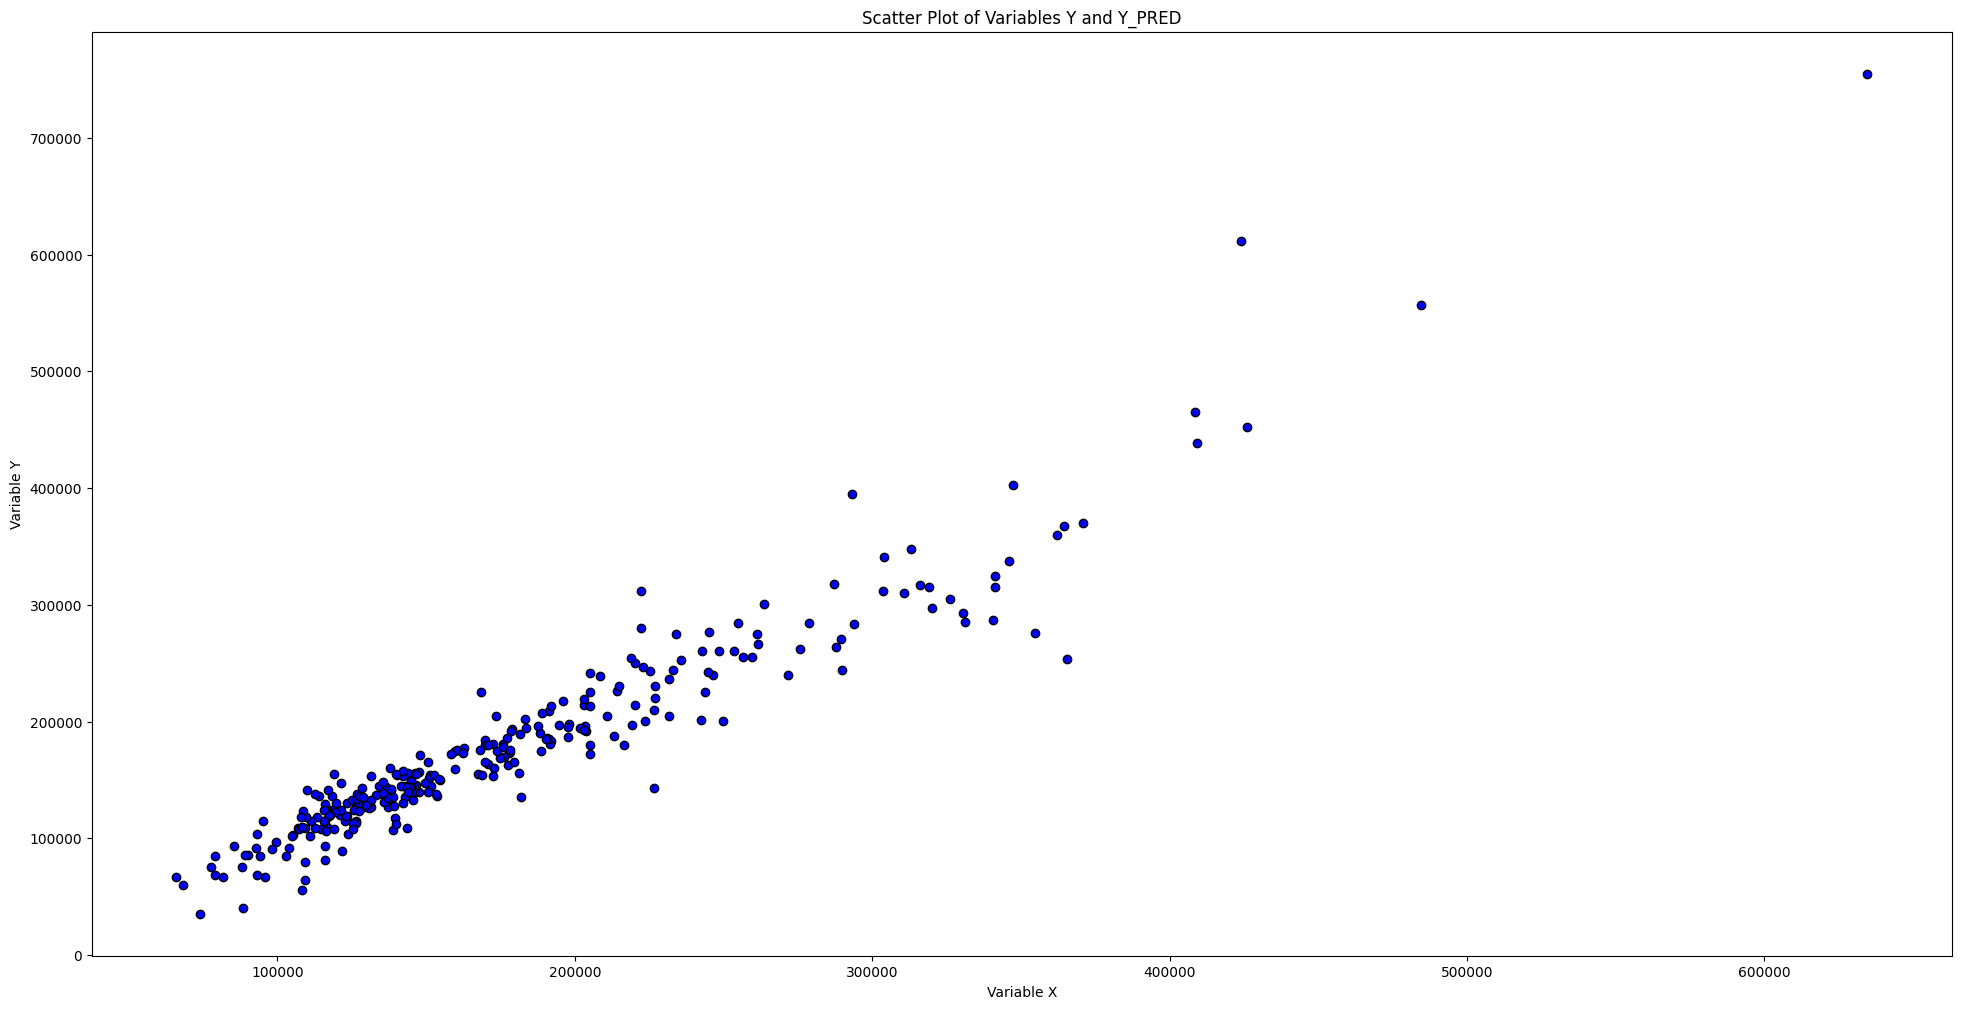

In [147]:
plt.figure(figsize=(24, 12))
plt.scatter(y_pred_test_hpt, list(y_test), color='blue', edgecolors='black') #, label=f"Correlation: {correlation:.2f}")
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.title('Scatter Plot of Variables Y and Y_PRED')
# plt.xlim(0, 100000)
# plt.ylim(0, 100000)

# z = np.polyfit(y_pred_test_hpt, y_test, 1)
# p = np.poly1d(z)
# plt.plot(y_pred_test_hpt, p(y_pred_test_hpt), "r--", linewidth=2, label=f"Trend line: y = {z[0]:.2f}x + {z[1]:.2f}")
plt.grid(False)
plt.show()

# 2.Model inference

In [206]:
df_test = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [207]:
cols = load('../models/columns.pkl')

ids = df_test['Id']
df_test = df_test[cols]

In [208]:
ordinal = load('../models/ordinal_encoder.pkl')

for index, col in enumerate(df_test.select_dtypes(include=['object']).columns):
    # print(index, col)
    valid = False
    for item in list(set(df_test[col])):
        if item in list(ordinal.categories_[index]):
            valid = True
        else:
            # valid = False
            print(item, ' \nTest array    ', list(set(df_test[col])), '\n\nEncoder array ', ordinal.categories_[index])
            ordinal.categories_[index] = np.append(ordinal.categories_[index], item)
            print('new encoder   ', ordinal.categories_[index], '\n')
            # break
    # print(valid)

    # print(list(set(df_test[i])))


nan  
Test array     ['C (all)', nan, 'RM', 'RL', 'FV', 'RH'] 

Encoder array  ['C (all)' 'FV' 'RH' 'RL' 'RM']
new encoder    ['C (all)' 'FV' 'RH' 'RL' 'RM' nan] 

nan  
Test array     ['HdBoard', nan, 'AsbShng', 'Plywood', 'VinylSd', 'Wd Sdng', 'BrkComm', 'AsphShn', 'WdShing', 'CemntBd', 'CBlock', 'MetalSd', 'BrkFace', 'Stucco'] 

Encoder array  ['AsbShng' 'AsphShn' 'BrkComm' 'BrkFace' 'CBlock' 'CemntBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Plywood' 'Stone' 'Stucco' 'VinylSd' 'Wd Sdng'
 'WdShing']
new encoder    ['AsbShng' 'AsphShn' 'BrkComm' 'BrkFace' 'CBlock' 'CemntBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Plywood' 'Stone' 'Stucco' 'VinylSd' 'Wd Sdng'
 'WdShing' nan] 

nan  
Test array     ['HdBoard', 'CBlock', nan, 'AsbShng', 'Stone', 'Plywood', 'VinylSd', 'BrkFace', 'Wd Sdng', 'AsphShn', 'ImStucc', 'Wd Shng', 'Brk Cmn', 'MetalSd', 'CmentBd', 'Stucco'] 

Encoder array  ['AsbShng' 'AsphShn' 'Brk Cmn' 'BrkFace' 'CBlock' 'CmentBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Other' 'Plywood' 'Stone' 'Stucco'

In [209]:
df_test[df_test.select_dtypes(include=['object']).columns] = ordinal.transform(df_test.select_dtypes(include=['object']))

In [210]:
standard = load('../models/standard_scaler.pkl')

df_test = standard.transform(df_test)

In [212]:
model = load('../models/model.joblib')

In [213]:
y_pred = model.predict(df_test)

In [214]:
submission_df = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
submission_df.to_csv('../data/house-prices-advanced-regression-techniques/submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


# 3.code refactoring

### Functions

In [185]:
ScalerType = Union[StandardScaler, MinMaxScaler]

# Constants
MODEL_PATH = '../models/'
DATA_PATH = '../data/house-prices-advanced-regression-techniques/'
THRESHOLD_NULL = 0.5
THRESHOLD_COUNT = 0.9


def dropping_null_columns(data: pd.DataFrame, threshold: float = THRESHOLD_NULL) -> pd.DataFrame:
    data = data.drop(columns=['Id'])
    columns_to_drop = [col for col in data.columns if data[col].isna().mean() >= threshold]
    return data.drop(columns=columns_to_drop)


def dropping_unnecessary_columns(data: pd.DataFrame, threshold: float = THRESHOLD_COUNT) -> pd.DataFrame:
    columns_to_drop = [col for col in data.columns if data[col].value_counts().max() > threshold * len(data)]
    return data.drop(columns=columns_to_drop)


def ordinal_encoding(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    ordinal = OrdinalEncoder()
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    ordinal.fit(X_train[categorical_columns])
    X_train[categorical_columns] = ordinal.transform(X_train[categorical_columns])
    X_test[categorical_columns] = ordinal.transform(X_test[categorical_columns])

    dump(ordinal, MODEL_PATH + 'ordinal_encoder.pkl')
    dump(X.columns, MODEL_PATH + 'columns.pkl')

    return X_train, X_test, y_train, y_test


def standardizing(X_train: pd.DataFrame, X_test: pd.DataFrame, scaler: ScalerType) -> Tuple[np.ndarray, np.ndarray]:
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    dump(scaler, MODEL_PATH + 'standard_scaler.pkl')

    return X_train, X_test


def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)


def evaluation(model: xgb.XGBRegressor, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    y_pred_test = model.predict(X_test)
    return {
        'R2': round(r2_score(y_test, y_pred_test), 2),
        'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2),
        'rmsle': compute_rmsle(y_test, y_pred_test)
    }


def tuning_eval(model: xgb.XGBRegressor, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    y_pred_test_hpt = model.predict(X_test)
    return {
        'R2': round(r2_score(y_test, y_pred_test_hpt), 2),
        'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred_test_hpt)), 2),
        'rmsle': compute_rmsle(y_test, y_pred_test_hpt)
    }


def build_model_before_tuning(data: pd.DataFrame) -> Tuple[xgb.XGBRegressor,
                                                           np.ndarray, np.ndarray,
                                                           np.ndarray, np.ndarray]:
    data = dropping_null_columns(data)
    data = dropping_unnecessary_columns(data)
    X = data.drop(columns=['SalePrice'])
    y = data['SalePrice']
    X_train, X_test, y_train, y_test = ordinal_encoding(X, y)
    X_train, X_test = standardizing(X_train, X_test, StandardScaler())

    xgb_reg = xgb.XGBRegressor(n_jobs=-1)
    xgb_reg.fit(X_train, y_train)
    dump(xgb_reg, MODEL_PATH + 'model_before_tuning.joblib')

    return xgb_reg, X_train, X_test, y_train, y_test


def encode_and_update(data: pd.DataFrame, ordinal_path: str) -> OrdinalEncoder:
    ordinal = load(ordinal_path)
    categorical_columns = data.select_dtypes(include=['object']).columns

    for index, col in enumerate(categorical_columns):
        unique_items = set(data[col])
        known_items = set(ordinal.categories_[index])
        new_items = unique_items - known_items

        if new_items:
            ordinal.categories_[index] = np.append(ordinal.categories_[index], list(new_items))

    dump(ordinal, MODEL_PATH + 'ordinal_encoder.pkl')
    return ordinal


def load_pkls() -> Tuple[pd.Index, ScalerType, xgb.XGBRegressor]:
    cols = load(MODEL_PATH + 'columns.pkl')
    standard = load(MODEL_PATH + 'standard_scaler.pkl')
    model = load(MODEL_PATH + 'model.joblib')
    return cols, standard, model


def make_prediction_before_tuning(data: pd.DataFrame) -> str:
    cols, standard, model = load_pkls()
    ids = data['Id']
    df_test = data[cols]
    ordinal = encode_and_update(df_test, MODEL_PATH + 'ordinal_encoder.pkl')

    df_test[df_test.select_dtypes(include=['object']).columns] = ordinal.transform(
        df_test.select_dtypes(include=['object']))
    df_test = standard.transform(df_test)

    y_pred = model.predict(df_test)
    submission_df = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
    submission_df.to_csv(DATA_PATH + 'submission.csv', index=False)

    return "Submission file created successfully."


def tuning(model: xgb.XGBRegressor, X_train: np.ndarray,
           X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    params = {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500, 750, 800, 850],
        'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5, 10, 12, 15, 20]
    }
    folds = 5
    param_comb = 100

    random_search = RandomizedSearchCV(model, param_distributions=params,
                                       n_iter=param_comb, n_jobs=-1,
                                       cv=folds, verbose=3,
                                       random_state=42)
    random_search.fit(X_test, y_test)

    best_params = random_search.best_params_
    xgb_reg_hpt = xgb.XGBRegressor(
        subsample=best_params['subsample'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        gamma=best_params['gamma'],
        colsample_bytree=best_params['colsample_bytree'],
        n_jobs=-1
    )
    xgb_reg_hpt.fit(X_train, y_train)
    clear_output(wait=False)
    dump(xgb_reg_hpt, MODEL_PATH + 'model.joblib')

    return {'model performance after tuning': evaluation(xgb_reg_hpt, X_test, y_test)}


In [186]:
def build_model(data: pd.DataFrame) -> Tuple[Dict[str, float], Dict[str, float]]:
    model, X_train, X_test, y_train, y_test = build_model_before_tuning(data)

    return ({'model performance before tuning': evaluation(model, X_test, y_test)},
            tuning(model, X_train, X_test, y_train, y_test))


def make_prediction(data: pd.DataFrame) -> pd.DataFrame:
    cols, standard, model = load_pkls()

    ids = data['Id']
    df_test = data[cols]
    ordinal = encode_and_update(df_test, MODEL_PATH + 'ordinal_encoder.pkl')
    df_test[df_test.select_dtypes(include=['object']).columns] = ordinal.transform(
        df_test.select_dtypes(include=['object']))
    
    df_test = standard.transform(df_test)

    y_pred = model.predict(df_test)
    submission_df = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
    submission_df.to_csv('../data/house-prices-advanced-regression-techniques/submission.csv', index=False)
    clear_output(wait=False)
    print("Submission file created successfully.")

    return submission_df


### Testing Functions

In [187]:
df = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')

In [188]:
build_model(df)

({'model performance before tuning': {'R2': 0.91,
   'rmse': 25792.78,
   'rmsle': 0.15}},
 {'model performance after tuning': {'R2': 0.91,
   'rmse': 25869.19,
   'rmsle': 0.14}})

In [189]:
make_prediction(df_test)

Submission file created successfully.


,Id,SalePrice
0,1461,127493.679688
1,1462,149294.750000
2,1463,179976.500000
3,1464,185986.828125
4,1465,200014.000000
...,...,...
1454,2915,83537.453125
1455,2916,87196.476562
1456,2917,172977.578125
1457,2918,121270.804688
